In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [ ]:
non_feature_columns = ['Ticker Symbol', 'Period Ending', 'Sector', 'For Year', 'Next Qtr. Avg. Price', 'Q avg to Q avg Price % Change', 'Y avg to Y avg Price % Change', 'Up or Down Q over Q', 'Up or Down Y over Y', 'Buy, Hold, or Sell']
less_useful_parameters = ["Add'l income/expense items", "Deferred Asset Charges", "Deferred Liability Charges", "Effect of Exchange Rate", "Minority Interest", "Misc. Stocks", "Non-Recurring Items", "Other Assets", "Other Current Assets", "Other Current Liabilities", "Other Equity", "Other Financing Activities", "Other Investing Activities", "Other Liabilities", "Other Operating Activities", "Other Operating Items"]
target_variable = 'Q avg to Q avg Price % Change'

# Load the merged dataset
fundamentals = pd.read_csv('../data/merged_data.csv')

# Count the number of stocks in each sector
sector_counts = fundamentals['Sector'].value_counts()

# Display the counts of all sectors
print(sector_counts)


Sector
Consumer Discretionary         249
Industrials                    219
Information Technology         216
Health Care                    154
Energy                         114
Consumer Staples                99
Materials                       89
Utilities                       88
Real Estate                     28
Telecommunications Services     20
Financials                      19
Name: count, dtype: int64


Total no. of features: 59

Accounts Payable                                      -0.014381
Accounts Receivable                                   -0.035878
After Tax ROE                                         -0.022980
Capital Expenditures                                   0.092267
Capital Surplus                                       -0.042888
Cash Ratio                                             0.075759
Cash and Cash Equivalents                             -0.029380
Changes in Inventories                                 0.030508
Common Stocks                                         -0.010139
Cost of Revenue                                        0.010094
Current Ratio                                          0.070116
Depreciation                                          -0.095276
Earnings Before Interest and Tax                       0.020400
Earnings Before Tax                                    0.022888
Equity Earnings/Loss Unconsolidated Subsidiary        -0.032595
Fixed Assets 

/tmp/ipykernel_4279/2279057655.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fundamentals[target_variable].fillna(method='bfill', inplace=True)
/tmp/ipykernel_4279/2279057655.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fundamentals[target_variable].fillna(method='bfill', inplace=True)


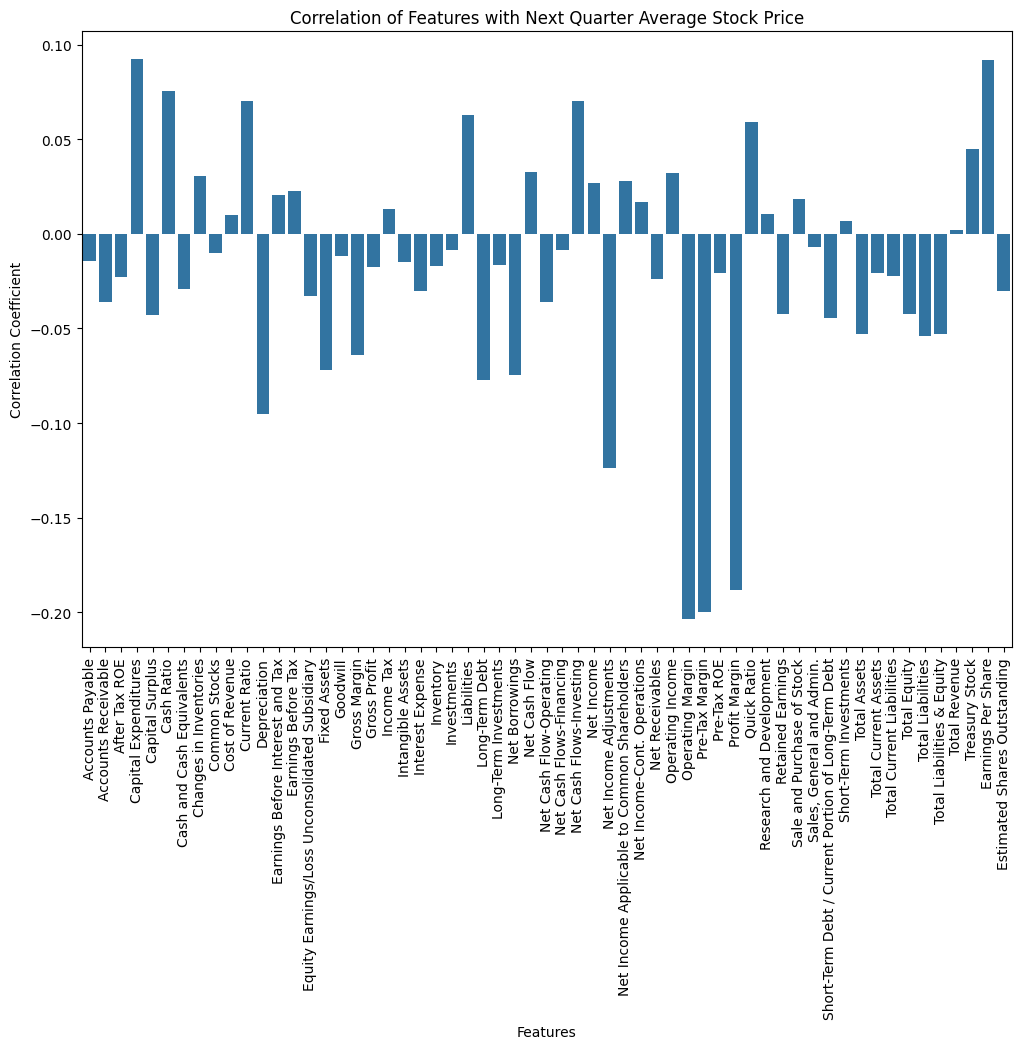

In [9]:
# Drop some columns which are redundant and less useful for fundamental analysis
fundamentals = fundamentals.drop(columns=less_useful_parameters)

# Check for NaN values in target variable and handle them
if fundamentals[target_variable].isna().sum() > 0:
    fundamentals[target_variable].fillna(method='bfill', inplace=True)

# Select features and target variable
features = fundamentals.drop(columns=non_feature_columns)
target = fundamentals[target_variable]

print(f'Total no. of features: {features.columns.size}\n')

# Combine features and target into a single DataFrame for correlation analysis
combined_data = pd.concat([features, target], axis=1)

# Calculate the correlation matrix
corr_matrix = combined_data.corr()

# Extract correlation of each feature with the target variable
target_corr = corr_matrix[target_variable].drop(target_variable)

# Display the correlation of each feature with the target variable
print(target_corr)

# Visualize the correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.xticks(rotation=90)
plt.title('Correlation of Features with Next Quarter Average Stock Price')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()


In [10]:
# Define LinearRegression model
model = LinearRegression()

# Initialize RFE to pick the top 30 out of the 59 features
rfe = RFE(estimator=model, n_features_to_select=30)

# Fit RFE
rfe.fit(features, target)

# Get the selected features
selected_features = features.columns[rfe.support_]

print(f'Selected Features:\n{selected_features}')

final_data = pd.DataFrame()
final_data['Ticker Symbol'] = fundamentals['Ticker Symbol']
final_data['Period Ending'] = fundamentals['Period Ending']
final_data[selected_features] = fundamentals[selected_features]
final_data[target_variable] = fundamentals[target_variable]

final_data.to_csv('../data/lr_data.csv')

Selected Features:
Index(['After Tax ROE', 'Capital Expenditures', 'Cash Ratio',
       'Changes in Inventories', 'Current Ratio',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Equity Earnings/Loss Unconsolidated Subsidiary', 'Gross Margin',
       'Interest Expense', 'Liabilities', 'Long-Term Debt', 'Net Borrowings',
       'Net Cash Flows-Financing', 'Net Income', 'Net Income Adjustments',
       'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Operations', 'Operating Income', 'Operating Margin',
       'Pre-Tax Margin', 'Pre-Tax ROE', 'Profit Margin', 'Quick Ratio',
       'Research and Development', 'Sale and Purchase of Stock',
       'Total Assets', 'Total Equity', 'Total Liabilities',
       'Earnings Per Share'],
      dtype='object')


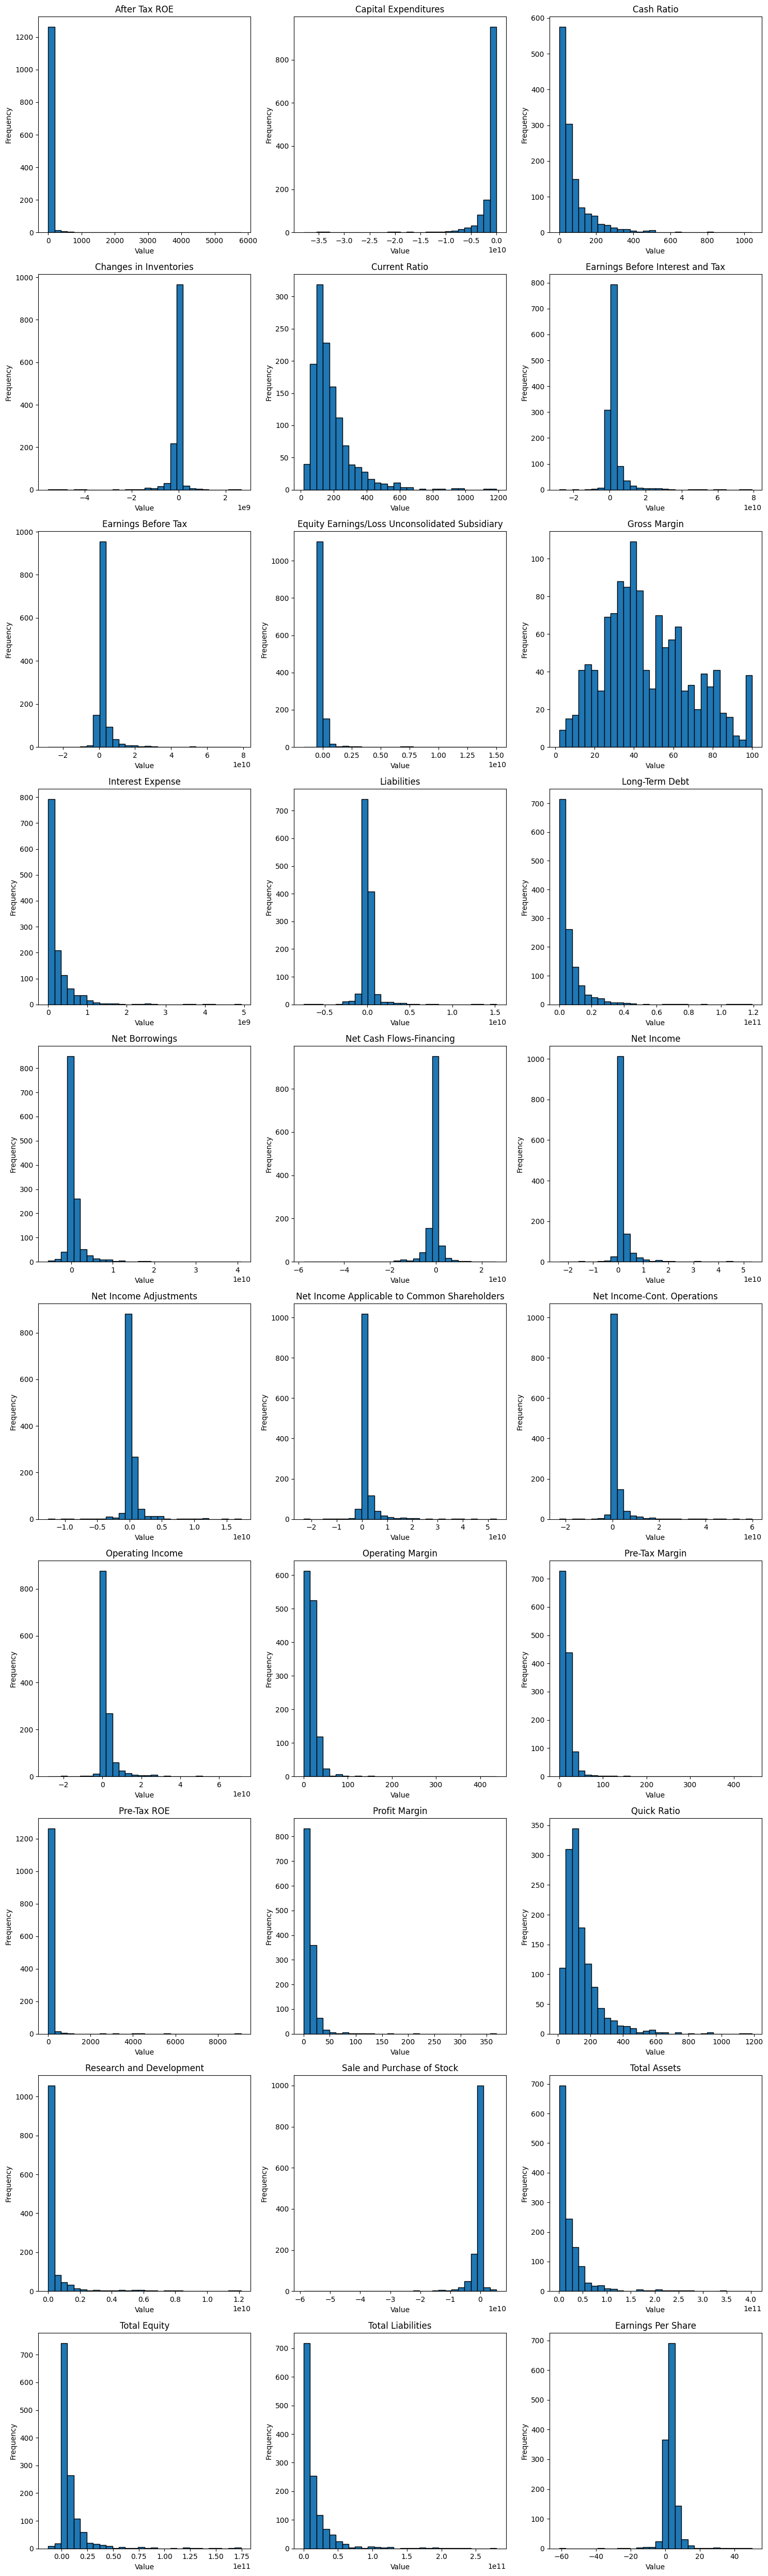

In [11]:
num_features = len(selected_features)

# Create a subplot grid
fig, axes = plt.subplots(nrows=num_features//3 + (num_features % 3 > 0), ncols=3, figsize=(15, 5*num_features//3 + (num_features % 3 > 0)))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    axes[i].hist(final_data[feature].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(feature)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


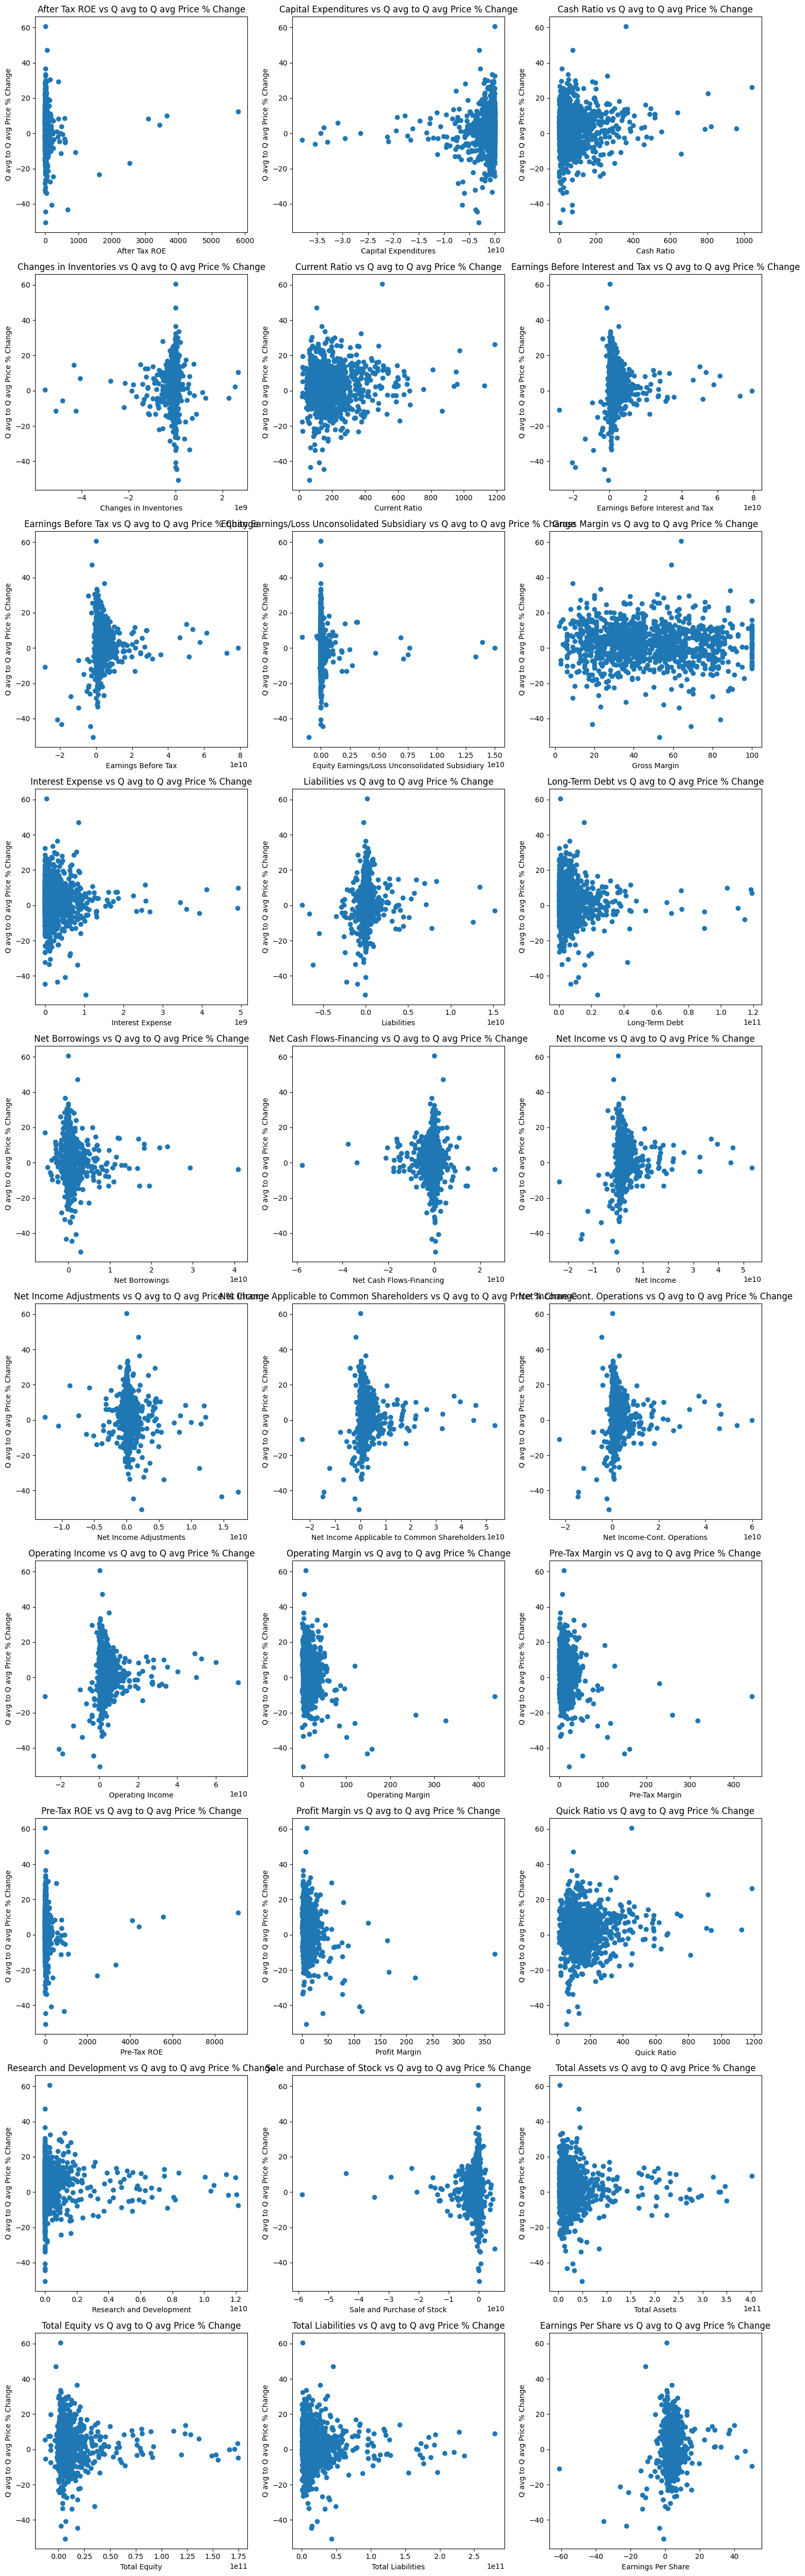

In [12]:
num_features = len(selected_features)

# Create a subplot grid
fig, axes = plt.subplots(nrows=num_features//3 + (num_features % 3 > 0), ncols=3, figsize=(15, 5*num_features//3 + (num_features % 3 > 0)))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    axes[i].scatter(final_data[feature], final_data[target_variable])
    axes[i].set_title(f'{feature} vs {target_variable}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_variable)

# Hide any unused subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
